# Fremskrivning af epidemikurven i Danmark

Dette dokument danner en eksponentiel fremskriver epidemikurven ud fra dagsaktuelle tal 
for smittede, indlagt og døde. 

## Metode
Vi anvender eksponentiel fremskrivning.

Det er en meget grovkornet metode, som kun kan bruges til kortsigtede fremskrivninger, da den ikke tager højde for
at epidemien over tid har færre og færre raske at ramme (dvs. at kurven begynder at bue nedad).

Den er dog relevant, da det er en fin måde at vise aktuelle data på og få en idé om den aktuelle vækstrate.

## Datagrundlag

Data er indhentet fra Sundhedsstyrelsens hjemmeside for 
[COVID-19 tal og overvågning](https://www.sst.dk/da/corona/tal-og-overvaagning).

Læs mere om datasættet på https://github.com/covid-19-sim/covid-19.sst.dk

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/covid-19-sim/covid-19.sst.dk/master/covid-19-dk.csv',
                 parse_dates=['Date'])

df

,Date,Tested,Confirmed,Hospitalised,ICU,ICU and ventilator,Death count
0,2020-03-11,NaN,NaN,0,0,0,1.0
1,2020-03-12,NaN,NaN,19,3,0,1.0
2,2020-03-13,NaN,NaN,23,4,0,1.0
3,2020-03-14,573.0,37.0,23,4,0,3.0
4,2020-03-15,1270.0,82.0,28,2,0,4.0
5,2020-03-16,2246.0,156.0,62,10,0,5.0
6,2020-03-17,3151.0,232.0,82,18,4,6.0
7,2020-03-18,4312.0,315.0,129,24,18,10.0
8,2020-03-19,6099.0,422.0,153,30,27,16.0
9,2020-03-20,7213.0,525.0,186,37,32,19.0


In [3]:
# Kontroller at data har det forventede format
for c in ['Date', 'Tested', 'Confirmed', 'Hospitalised', 'ICU', 'ICU and ventilator', 'Death count']:
    assert c in df.columns    

In [4]:
epidemi_start = np.min(df['Date'])

df['Day'] = df['Date'] - epidemi_start
df['Day N'] = df['Day'].dt.days


## Faktiske indlæggelser og dødsfald
Datasættet ser således ud når vi tegner graferne med henholdsvis lineær og logaritmisk y-akse.
Husk at en ret linie på logaritmisk y-akse svarer til konstant procentuel daglig tilvækst.   

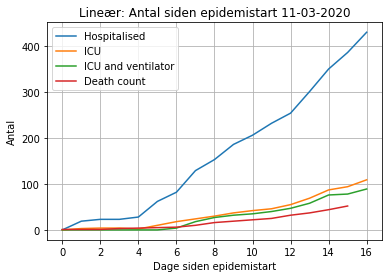

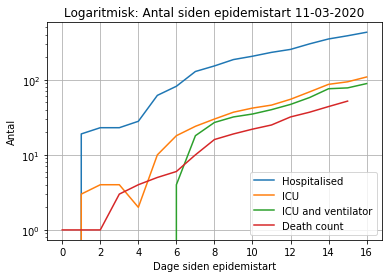

In [5]:
kolonner = ['Hospitalised', 'ICU', 'ICU and ventilator', 'Death count']

for is_log_plot, titel in [[False, "Lineær"], [True, "Logaritmisk"]]:
    df.plot(x='Day N', y=kolonner, grid=True, logy=is_log_plot,
            title=f'{titel}: Antal siden epidemistart {epidemi_start.date().strftime("%d-%m-%Y")}')
    plt.xlabel('Dage siden epidemistart')
    plt.ylabel('Antal')
    plt.show()

## Eksponentiel fremskrivning

Vi estimerer $a$ og $b$ en simpel eksponentialfunktion til dødsfaldskurven, 

$$\hat{y} = a e^{b x}$$ 

$x$ er dage siden epidemistart, $\hat{y}$ er det estimere antal døde. 

SciPy har en indbygget funktion til at dette, `curve_fit`:

In [6]:
# Hvis ikke vi har observationen, så drop rækken
df_renset = df[['Day N', 'Death count']].dropna()

x_data = df_renset['Day N']
y_data = df_renset['Death count']

def exp_func(x, a, b):
    return a * np.exp(b * x)

popt, pcov = scipy.optimize.curve_fit(exp_func, x_data, y_data)

In [7]:
# Højeste dato med en faktisk observation, herefter følger prognosen
day_N_max = int(np.max(x_data))
date_max = datetime.timedelta(days=day_N_max) + epidemi_start

In [8]:
FREMSKRIV_DAGE = 14
x_data_fremskrivning = np.arange(day_N_max, day_N_max+FREMSKRIV_DAGE)
y_data_fremskrivning = exp_func(x_data_fremskrivning, *popt)

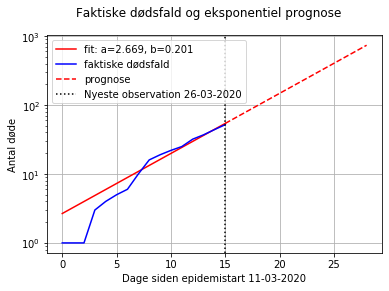

In [9]:
plt.plot(x_data, exp_func(x_data, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_data, y_data, 'b-', label='faktiske dødsfald')
plt.plot(x_data_fremskrivning, y_data_fremskrivning, 'r--', label='prognose')
plt.xlabel(f'Dage siden epidemistart {epidemi_start.strftime("%d-%m-%Y")}')
plt.ylabel('Antal døde')
plt.axvline(day_N_max, color='k', linestyle=':', 
            label=f'Nyeste observation {date_max.date().strftime("%d-%m-%Y")}')
plt.legend()
plt.suptitle('Faktiske dødsfald og eksponentiel prognose')
plt.yscale('log')
plt.grid()
plt.show()